## 시계열 데이터 결측치 처리


### 0. 라이브러리 불러오기 & 데이터 준비

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

df= pd.read_csv('seattle-weather.csv') # 시계열 데이터 불리오기

In [2]:
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [3]:
df.info() # date 의 타입이 object > datetime으로 타입 변경이 필요하다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


- 결측치 확인

In [4]:
df.isna().sum() # 결측치 없음

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

- 분포 확인

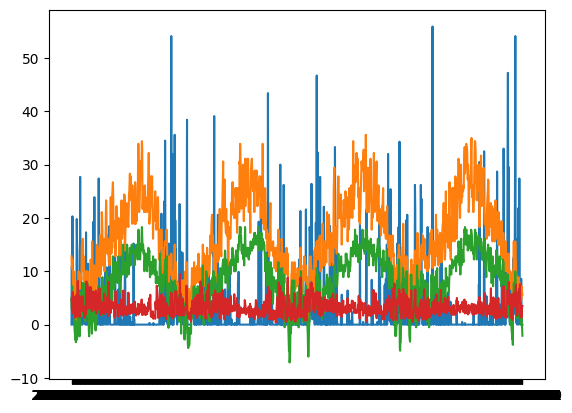

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

cols =  ['precipitation', 'temp_max', 'temp_min', 'wind']

fig,ax = plt.subplots()
for col in cols:
   ax.plot(df['date'], df[col], label = col)
plt.show()

### 1. 결측치 임의 생성
- 'precipitation'을 y로, 'date','temp_max','temp_min','wind'를 x로 하는 모델로 선형보간법을 진행하여 모델 성능을 확인할 것이다.

In [6]:
df_x = df[['temp_max','temp_min','wind']]

In [7]:
## 결측치를 임의로 만들어야 하는 상황
msv = np.random.randint(0,389, size=40) # 40개의 무작위 정수를 msv 배열에 저장
df_x.iloc[msv] = np.nan # msv 행 인덱스를 사용하여 지정된 인덱스에 np.nan 값 부여
# 결측치 만들기
df_x.isna().sum()

<ipython-input-7-5e393bea1303>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x.iloc[msv] = np.nan # msv 행 인덱스를 사용하여 지정된 인덱스에 np.nan 값 부여


temp_max    40
temp_min    40
wind        40
dtype: int64

In [8]:
df_t = pd.concat([df_x,df['date'],df['precipitation']], axis = 1) # 선형보간(method = 'time')
df_t1 = pd.concat([df_x,df['precipitation']], axis = 1) # impute

### 3. 결측치 채우기

- 선형보간법 사용

In [9]:
df_t['date'] = pd.to_datetime(df_t['date'])
df_t.set_index('date', inplace=True)
df_t = df_t.interpolate(method = 'time')

- Simple imputer(mean/median/most_frequent)

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer # 임퓨터 불러오기

# SimpleImputer 인스턴스 생성
mean_imputer = SimpleImputer()
median_imputer = SimpleImputer(strategy='median', fill_value=None, verbose=0, copy=True, add_indicator=False)
most_imputer = SimpleImputer(strategy='most_frequent', fill_value=None, verbose=0, copy=True, add_indicator=False)
# strategy가 constant(지정값)인 경우에는 fill_value값을 적어줘야 한다.

In [11]:
df_mean = pd.DataFrame(mean_imputer.fit_transform(df_t1))
df_median = pd.DataFrame(median_imputer.fit_transform(df_t1))
df_most = pd.DataFrame(most_imputer.fit_transform(df_t1))

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:382: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:382: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


- Iterative Imputer

In [12]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(imputation_order = 'descending',
                          max_iter=10, random_state=111,
                          n_nearest_features=4)

df_itr =pd.DataFrame(imputer.fit_transform(df_t1))

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [13]:
df_mean

,0,1,2,3
0,12.8,5.0,4.7,0.0
1,10.6,2.8,4.5,10.9
2,11.7,7.2,2.3,0.8
3,12.2,5.6,4.7,20.3
4,8.9,2.8,6.1,1.3
...,...,...,...,...
1456,4.4,1.7,2.9,8.6
1457,5.0,1.7,1.3,1.5
1458,7.2,0.6,2.6,0.0
1459,5.6,-1.0,3.4,0.0


In [14]:
# 확인
df_mean.isna().sum()

0    0
1    0
2    0
3    0
dtype: int64

In [15]:
#컬럼명 바꿔주기(simpleImputer 사용할 경우, numpy 배열로 나옴)
df_mean.columns = ['temp_max','temp_min','wind','precipitation']
df_median.columns = ['temp_max','temp_min','wind','precipitation']
df_most.columns = ['temp_max','temp_min','wind','precipitation']
df_itr.columns = ['temp_max','temp_min','wind','precipitation']

### 회귀분석

- 회귀분석 테스트 함수

In [16]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def mse_test(data):
  X_train, X_test, y_train, y_test = train_test_split(data.drop('precipitation', axis=1), data['precipitation'], test_size=0.3, random_state=111)
  fit_train = sm.OLS(y_train, X_train)
  fit_train = fit_train.fit()

  mse = mean_squared_error(y_true=y_test, y_pred=fit_train.predict(X_test))

  # 시각화 코드
  plt.plot(np.array(fit_train.predict(X_test)), label='pred')
  plt.plot(np.array(y_test), label='True')
  plt.legend()
  plt.show()

  return mse

- 선형보간

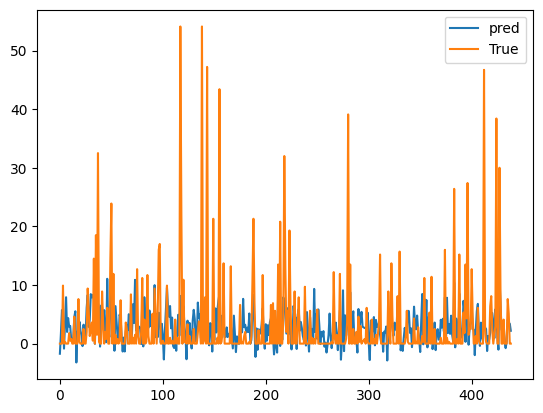

47.15698626290301

In [17]:
mse_test(df_t)

- simpleimputer(strategy = 'mean')

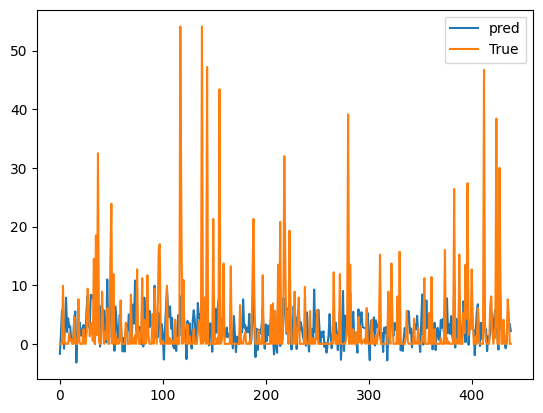

47.200015812078554

In [18]:
mse_test(df_mean)

- simpleimputer(strategy = 'median')

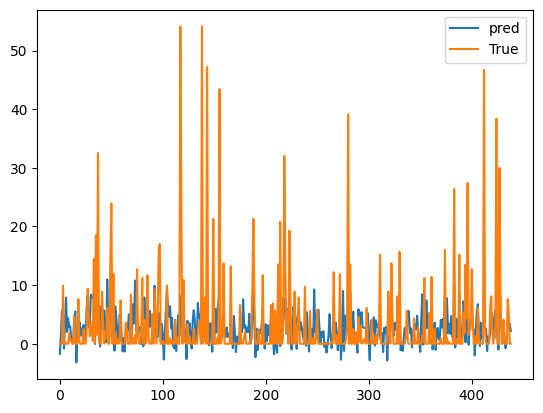

47.19312106746696

In [19]:
mse_test(df_median)

- simpleimputer(strategy = 'most_frequent')

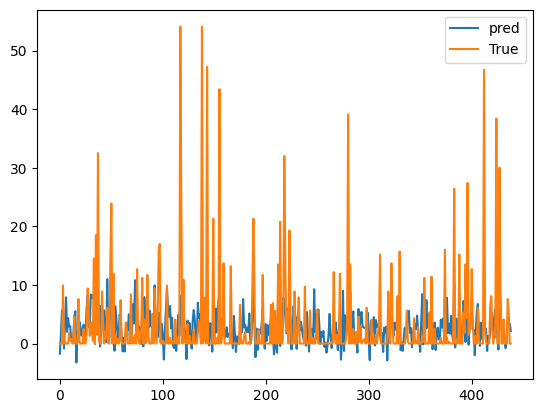

47.18673224704773

In [20]:
mse_test(df_most)

- Iterative Imputer

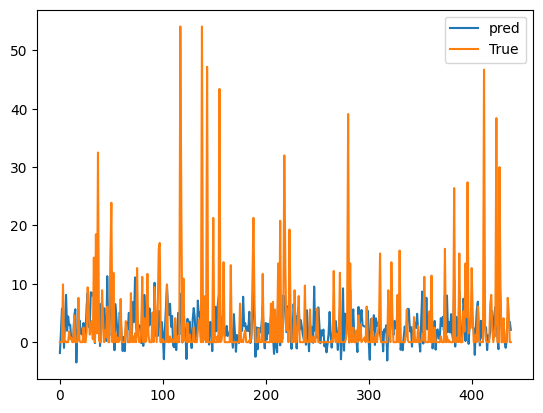

46.97680025211388

In [21]:
mse_test(df_itr)